##0. Librerías y dependencias

Para garantizar el correcto funcionamiento de los desarrollos realizados en el presente Notebook, es requerida la instalación de las siguientes librerías:

In [ ]:
!pip install unidecode

from google.colab import drive
import pandas as pd
import re
import numpy as np
from unidecode import unidecode
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from IPython.display import Image, display


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.8 MB/s eta 0:00:00


Adicionalmente, se confirman las dependencias extras que se pueden tener con sus respectivas versiones:

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bidict                           0.23.1

##1. Importar información

Para realizar la carga de los documentos dentro del Notebook, primero se realiza la carga de los archivos *train_precios_vivienda.csv* y *test_precios_vivienda.csv* a Google Drive, posteriormente se realiza una conexión a este repositorio

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Se procede a la carga del archivo *train_precios_vivienda.csv*

In [ ]:
ruta_archivos = '/content/drive/MyDrive/Prueba ADNE/vivienda'

train_data = pd.read_csv( ruta_archivos + "/train_precios_vivienda.csv", low_memory = False)
train_data.head()

,Unnamed: 0,id,fecha_aprobación,objeto,motivo,proposito,tipo_avaluo,tipo_credito,tipo_subsidio,departamento_inmueble,...,valor_area_construccion,area_otros,valor_area_otros,area_libre,valor_area_libre,valor_total_avaluo,valor_uvr,valor_avaluo_en_uvr,Longitud,Latitud
0,4112,5896,43090.624747,Remate,Remates,GarantÃ­a Hipotecaria,Remates,Vivienda,NaN,VALLE DEL CAUCA,...,"81968750,00",0,0,0,0,"145318750,00",2522304,"576134,95",0.000000,0.000000
1,7401,10570,NaN,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,NaN,QUINDÃO,...,0,157,78500000,No,0,713986654,257.23250000000002,2775647.14,-75.661152,4.544027
2,10223,14600,NaN,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,NaN,ANTIOQUIA,...,0,0,0,Si,0,270500000,259.4264,1042684.94,-75.584116,6.277020
3,4170,5967,43091.676139,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,VIS,CUNDINAMARCA,...,0,0,0,No,0,"84840000,00",252245,"336339,67",0.000000,0.000000
4,11073,15814,NaN,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,VIS,META,...,69306400,0,0,0,0,96346400,259.72770000000003,370951.58,-73.712370,3.565757


Se verifica el tamaño del conjunto de datos creado, obteniendo un total de 11.571 registros con 222 variables.

In [ ]:
train_data.shape

(11571, 222)

Se procede a la carga del archivo *test_precios_vivienda.csv*

In [ ]:
test_data = pd.read_csv( ruta_archivos + "/test_precios_vivienda.csv", low_memory = False , sep = ';')
test_data.head()

,id,fecha_aprobación,objeto,motivo,proposito,tipo_avaluo,tipo_credito,tipo_subsidio,departamento_inmueble,municipio_inmueble,...,area_terreno,valor_area_terreno,area_construccion,valor_area_construccion,area_otros,valor_area_otros,area_libre,valor_area_libre,Longitud,Latitud
0,2243,430.144.469.211.111,Originación,Crédito hipotecario de vivienda,Garantía Hipotecaria,Hipotecario,Vivienda,NaN,MAGDALENA,SANTA MARTA,...,0,0,0,0,0,0,No,0,0.0,0.0
1,500,429.894.007.425.116,Originación,Crédito hipotecario de vivienda,Garantía Hipotecaria,Hipotecario,Vivienda,NaN,MAGDALENA,CIENAGA,...,136,27200000,80,44800000,0,0,0,0,0.0,0.0
2,12884,NaN,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,NaN,TOLIMA,MELGAR,...,0,0,0,0,348.23,90539800,No,0,-74.643.383,4.203.572
3,4019,430.486.908.754.861,Originación,Actualización de garantías,Garantía Hipotecaria,Hipotecario,Vivienda,NaN,CESAR,VALLEDUPAR,...,0,0,0,0,0,0,Si,0,0.0,0.0
4,11584,NaN,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,NaN,HUILA,PITALITO,...,0,0,0,0,75.239.999.999.999.900,41382000,No,0,-760.631.391,18.413.391


Se verifica el tamaño del conjunto de datos creado, obteniendo un total de 417 registros con 218 variables. Al realizar la comparación de tamaños, vemos que para el conjunto de prueba se dejó menos del 5% de registros de la base total, adicionalmente, cuenta con 4 variables menos que el conjunto de entrenamiento, por lo cual se procede a la validación de las columnas de diferencia.

In [ ]:
test_data.shape

(417, 218)

Se observa que de las 4 variables de diferencia entre los conjuntos de datos, 3 corresponden a la variable de interés a predecir, por lo tanto se asume que está información no estará disponible en el conjunto de datos de testeo, lo cual no permitirá la generación de métricas fuera del conjunto de entrenamiento. Referente a la variable faltante, es información agregada no útil en el análisis, por lo cual se procede a la eliminación de la misma.

In [ ]:
train_data.columns.difference(test_data.columns)

Index(['Unnamed: 0', 'valor_avaluo_en_uvr', 'valor_total_avaluo', 'valor_uvr'], dtype='object')

In [ ]:
train_data.drop(columns=['Unnamed: 0'], inplace=True)

Con la finalidad de poder ejecutar la tarea de limpieza de la base información, se unen ambos conjuntos de datos, pero antes de ello, se añade la columna Base, que ayudará a la identificación del origen de cada registro, ya que será requerido posteriormente en la fase de entrenamiento.

In [ ]:
train_data['Base']='Entrenamiento'
test_data['Base']='Prueba'


df_full= pd.concat([train_data,test_data],ignore_index=True)
df_full.shape

(11988, 222)

##2. Limpieza de datos

El conjunto de datos cuenta con más de 200 variables, sin embargo, no todas ellas pueden ser de utilidad para el desarrollo, ya sea porque su información es inconsistente o no tienen relación estadísticamente significa con la variable a predecir, por lo cual en esta sección se realiza la limpieza de datos que permita el correcto ajuste del modelo, recordemos que un buen modelo depende de buena información.

En primer lugar, se realiza la eliminación de variables que no aportan información valiosa al análisis:

In [ ]:
var_eliminar=['fecha_aprobación']
df_full.drop(columns=var_eliminar, inplace=True)

Teniendo en cuenta que el objetivo de este proyecto no es el realizar un análisis detallado de variables que contengan mucho texto, se procede a realizar la identificación de variables con muchos caracteres para posteriormente definir si deben ser eliminadas. Inicialmente, nos enfocaremos en las variables que tienen más de 50 caracteres.

In [ ]:
vars=[]

for column in df_full.columns:
  max_length = max(df_full[column].apply(str).apply(len))
  if max_length > 50:
    vars.append(column)

df_full[vars].head()

,direccion_inmueble_informe,descripcion_general_sector,perspectivas_de_valorizacion,actualidad_edificadora,comportamiento_oferta_demanda,alcantarillado_en_el_predio,acueducto_en_el_predio,gas_en_el_predio,energia_en_el_predio,observaciones_generales_inmueble,...,metodo_valuacion_7,concepto_del_metodo_7,metodo_valuacion_8,concepto_del_metodo_8,metodo_valuacion_9,concepto_del_metodo_9,valor_area_privada,valor_area_garaje,area_deposito,valor_area_deposito
0,CL 28 A # 32 - 21,Sector ubicado en la zona central del municipi...,Son buenas por la ubicaciÃ³n del inmueble en u...,Sector en completo desarrollo sin actividad ed...,La oferta es similar a la demanda.,Si,Si,Si,Si,Vivienda unifamiliar de un piso de reciente re...,...,0,0,ComparaciÃ³n de Mercado Lote en Venta (Terreno...,DE ACUERDO A OFERTAS DE INMUEBLES CON CARACTER...,0,0,0,0,0,0
1,CL 1 # 11 - 70 CONJUNTO RESIDENCIAL PALMAS DE ...,"El sector es de uso residencial, de educacion ...","Las perspectivas de valorizaciÃ³n son buenas, ...","La actividad edificadora es alta, con proyecto...",La oferta es ligeramente mayor que la demanda.,Si,Si,Si,Si,"Inmueble se identifica fisciamente nuevo, sin ...",...,0,0,ComparaciÃ³n de Mercado Lote en Venta (Terreno...,Se utiliza la metodologÃ­a de comparaciÃ³n ya ...,0,0,635486654,0,0,0
2,KR 73 B # 75 - 191 APTO 9906,El inmueble estÃ¡ ubicado en una zona residenc...,De acuerdo con las perspectivas de la activida...,En las inmediaciones en la actualidad se obser...,De la investigaciÃ³n econÃ³mica de inmuebles e...,Si,Si,Si,Si,Inmueble en buenas condiciones generales. El i...,...,0,0,0,0,0,0,246000000,22000000,1.02,2500000
3,TV 19 # 39 C - 105 BLOQUE D AP 903,"Sector de uso residencial, consolidado en edif...",Se trata de una zona consolidada. Dada la situ...,Sector consolidado de la ciudad donde predomin...,Del anÃ¡lisis del segmento del mercado relativ...,Si,Si,Si,No,No se presentan diferencias entre lo fÃ­sico y...,...,0,0,0,0,0,0,"84840000,00",0,0,0
4,CASA 21 MANZANA N2,SECTOR EN DESARROLLO SE GENERAN VARIOS ...,DE LA ACTIVIDAD EDIFICADORA Y EL MERCADO INMOB...,"SE OBSERVA UNA ALTA ACTIVIDAD EDIFICADORA, DIR...",SE EVIDENCIA EL INTERÃ‰S DEL SECTOR PRIVADO PO...,Si,Si,Si,Si,"BUENAS CONDICIONES DE ACCESO AL SECTOR, YA QUE...",...,0,0,ComparaciÃ³n de Mercado Lote en Venta (Terreno...,TÃ‰CNICA VALUATORIA QUE BUSCA ESTABLECER EL VA...,0,0,0,0,0,0


Se realiza la detección de 52 variables, sin embargo, variables como *alcantarillado_en_el_predio* a simple vista no parecen tener valores con esa longitud, puede que sean espacios dentro de los registros o algún registro atípico, lo cual será evaluado posteriormente, de momento solo serán eliminas las variables de esta selección, que a simple vista contienen caracteres mayores al umbral propuesto.

In [ ]:
var_eliminar = [
    'direccion_inmueble_informe', 'perspectivas_de_valorizacion',
    "descripcion_general_sector", "actualidad_edificadora",
    "comportamiento_oferta_demanda", "observaciones_generales_inmueble",
    "observaciones_estructura", "observaciones_dependencias",
    "observaciones_generales_construccion", "concepto_del_metodo_3",
    "concepto_del_metodo_5", "concepto_del_metodo_8",
    "metodo_valuacion_8", "concepto_del_metodo_8",
    "descripcion_tipo_inmueble", "descripcion_uso_inmueble",
    "descripcion_clase_inmueble", "concepto_del_metodo_6",
    "concepto_del_metodo_9", "concepto_del_metodo_7",
    "metodo_valuacion_9", "metodo_valuacion_1",
    "tipo_subsidio", "uso_actual"
]

df_full.drop(columns=var_eliminar, inplace=True)

Con el fin de entender el comportamiento de las variables no fueron eliminadas en el punto anterior, pero que en alguno de sus campos presentan una longitud mayor a 50 caracteres, se emplea el siguiente código para poder visualizar de una mejor forma dichos registros:

In [ ]:
lenth_maximum = []

for column in df_full.columns:
  max_length = max(df_full[column].apply(str).apply(len))
  if max_length > 50:
    lenth_maximum.append(column)

mask = df_full[lenth_maximum].applymap(lambda x: len(str(x)) > 50).any(axis=1)
df_full.loc[mask, lenth_maximum]

,alcantarillado_en_el_predio,acueducto_en_el_predio,gas_en_el_predio,energia_en_el_predio,condicion_ph,numero_piso,numero_de_edificios,vetustez,habitaciones,estar_habitacion,...,metodo_valuacion_3,metodo_valuacion_4,concepto_del_metodo_4,metodo_valuacion_5,metodo_valuacion_6,metodo_valuacion_7,valor_area_privada,valor_area_garaje,area_deposito,valor_area_deposito
279,No,Si,No,No,en cuanto a la construcción hay 5.6 M2 de mas ...,0,No,2017,"""Estructura tradicional en aparente buen estad...",2,...,0,0,0,0,0,0,0,0,0,0
360,"""La oferta es media, con demanda escasa. No se...",Si,Si,Si,"""Cumple con la norma general para la zona rura...",0,No,1965,"""Presenta una parte de la construcción en baha...",6,...,0,0,0,0,0,0,Comparación de Mercado Lote en Renta (Terreno ...,"12,0",0,0
470,"""Equilibrio entre oferta y demanda""",Si,Si,Si,"""El avalúo comprende un apartamento nuevo en s...",Construccion,No,2017,"""Durante la inspección física no se observan a...",3,...,0,0,0,0,""": SE REALIZO POR MÉTODO COMPARATIVO O DE MER...",0,"56,08",0,0,0
541,Si,Si,Si,Si,Certificado de Tradición y Libertad Matrícula ...,Construccion,No,1994,"""Estructura en muro de carga, de dos pisos, en...",4,...,0,0,0,0,"""Mediante un estudio comparativo del mercado i...",0,"124,4",0,0,0
694,con buena ubicación con respecto al sur de la ...,"""En crecimiento: multifamiliares en torres de ...",se adelanta un proyecto de este tipo en proxim...,"""Se mantiene en equilibrio gracias al crecimie...",0,0,"""No se presenta diferencias entre lo físico y ...",Si,Bueno,Sin irregularidad,...,0,0,0,0,0,Comparación de Mercado PH en Venta,0,"5,0","54,1","99587280,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11186,Si,Si,No,Si,0,0,0,65,3,0,...,0,Metodo Residual,"""Se realizó por método comparativo o de mercad...",0,0,Comparación de Mercado Lote en Venta,0,0,0,0
11362,Si,Si,Si,Si,el área construida medida en sitio con cinta m...,0,No,2008,"""Inmueble con vigas, columnas, placa de entrep...",6,...,0,"""Para la construcción estructura de costo para...",0,0,0,0,0,0,0,0
11494,"""buenas acordes con la dinámica inmobiliaria d...",Si,Si,Si,"""El inmueble se encuentra en buen estado en el...",Terreno,Si,1989,"""estructura sismo resistente sin daños previos...",3,...,0,0,0,0,0,0,"90,04",0,0,0
11527,Si,Si,Si,Si,0,0,0,27,4,0,...,0,Método Reposición,"""Se aplica el método de reposición para determ...",0,0,0,"8,8",0,0,0


Tal como se pensaba inicialmente, existen 139 valores atípicos en las 34 variables restantes, por lo cual se procede a la eliminación de los registros.

In [ ]:
df_full = df_full[~mask]

Se procede a verificar la distribución del tipo de variables que se están manejando dentro del conjunto de datos:

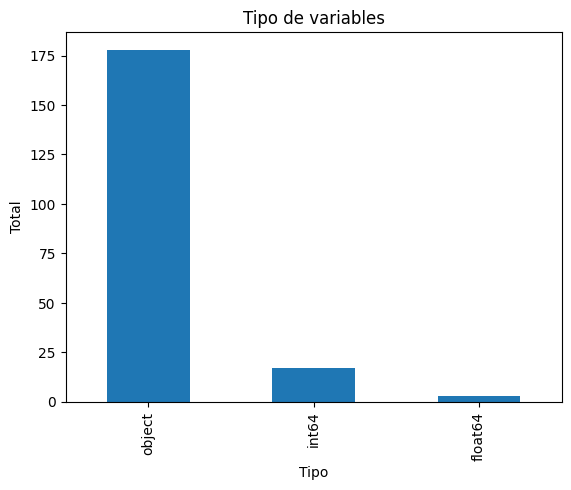

In [ ]:
tipos = pd.DataFrame([df_full.dtypes.index,df_full.dtypes.values]).transpose()
tipos.columns = ['Columna', 'Tipo']

tipos["Tipo"].value_counts().plot(kind='bar')

plt.xlabel('Tipo')
plt.ylabel('Total')
plt.title('Tipo de variables')

plt.show()

Se encuentra que la mayoría de variables son de tipo object, sin embargo, se procede a revisar las variables que tienen este tipo para determinar si existen algunas numéricas afectas por valores atípicos, que pueden estar cambiando su naturaleza.

In [ ]:
categoricas=tipos[ tipos['Tipo']=='object']['Columna'].values
print(categoricas)

['objeto' 'motivo' 'proposito' 'tipo_avaluo' 'tipo_credito'
 'departamento_inmueble' 'municipio_inmueble' 'barrio' 'sector'
 'alcantarillado_en_el_sector' 'acueducto_en_el_sector' 'gas_en_el_sector'
 'energia_en_el_sector' 'telefono_en_el_sector' 'vias_pavimentadas'
 'sardineles_en_las_vias' 'andenes_en_las_vias' 'estrato' 'barrio_legal'
 'topografia_sector' 'condiciones_salubridad' 'transporte'
 'demanda_interes' 'paradero' 'alumbrado' 'arborizacion' 'alamedas'
 'ciclo_rutas' 'nivel_equipamiento_comercial'
 'alcantarillado_en_el_predio' 'acueducto_en_el_predio' 'gas_en_el_predio'
 'energia_en_el_predio' 'telefono_en_el_predio' 'tipo_inmueble'
 'clase_inmueble' 'ocupante' 'sometido_a_propiedad_horizontal'
 'altura_permitida' 'observaciones_altura_permitida'
 'aislamiento_posterior' 'observaciones_aislamiento_posterior'
 'aislamiento_lateral' 'observaciones_aislamiento_lateral' 'antejardin'
 'observaciones_antejardin' 'indice_ocupacion'
 'observaciones_indice_ocupacion' 'indice_construc

Inicialmente, revisando las variables a alto nivel, se esperaría que variables como *Estrato* o *numero_total_de_garajes* sean numéricas, esto refuerza la teoría de que un valor atípico está cambiando la naturaleza de la variable, por lo cual se procede a la identificación de los registros.

In [ ]:
def num_string(x):
  cont=0
  if isinstance(x, str):
    if bool(re.search('[a-zA-Z]', x)):
      cont= cont+1
  else:
    cont= cont+1
  return cont

var_num_strings = df_full.applymap(num_string)

Para las variables que tengan menos de 200 registros del total con caracteres, se hará una limpieza eliminando dichos registros.

In [ ]:
conteo_string=pd.DataFrame({ "Variables":var_num_strings.sum().index , "Conteo": var_num_strings.sum().values }  )
arreglar_registros = conteo_string[ (conteo_string["Conteo"] < 200) & (conteo_string["Conteo"] >0)  ].sort_values(by='Conteo')
arreglar_registros

,Variables,Conteo
185,valor_area_terreno,1
48,observaciones_indice_ocupacion,6
18,estrato,7
139,numero_garaje_3,7
140,matricula_garaje_3,18
159,numero_deposito_1,46
141,garaje_cubierto_3,92
142,garaje_doble_3,92
143,garaje_paralelo_3,92
144,garaje_servidumbre_3,92


Se procede a la eliminación de estos registros:

In [ ]:
def have_string(x):
  if isinstance(x, str):
    return bool(re.search('[a-zA-Z]', x))
  else:
    return False

filtro = df_full.applymap(have_string)
filtro = filtro[ arreglar_registros["Variables"] ]
filtro = ~filtro

df_full = df_full.loc[filtro.all(axis=1)]

df_full.shape

(11556, 198)

Se procede a la eliminación de variables que tengan entre 200 y 2.000 registros con un formato diferente al original, dado que eliminar estos registros de la base impactaría de forma negativa la cantidad de información en el desarrollo.

In [ ]:
borrar_variable = conteo_string[ (conteo_string["Conteo"] < 5000) & (conteo_string["Conteo"] >=200) & (conteo_string["Variables"] != "valor_total_avaluo"  ) ].sort_values(by='Conteo')
print(borrar_variable)
df_full.drop(columns=borrar_variable["Variables"].to_numpy(), inplace=True)

                             Variables  Conteo
127                    numero_garaje_1     220
160  matricula_inmobiliaria_deposito_1     274
163                  numero_deposito_3     417
165                  numero_deposito_4     417
169              concepto_del_metodo_1     417
179                 valor_area_privada     417
181                  valor_area_garaje     417
183                valor_area_deposito     417
187            valor_area_construccion     417
189                   valor_area_otros     417
191                   valor_area_libre     417
126             total_cupos_parquedaro     417
125            numero_total_de_garajes     417
96                        bano_privado     417
40      observaciones_altura_permitida     417
94                                sala     417
53                     contadores_agua     417
54                      contadores_luz     417
95                             comedor     417
55                          accesorios     417
52           

Verificamos nuestra base, identificando que en este momento ya contamos con 139 variables.

In [ ]:
df_full.head()

,id,objeto,motivo,proposito,tipo_avaluo,tipo_credito,departamento_inmueble,municipio_inmueble,barrio,sector,...,area_deposito,area_terreno,valor_area_terreno,area_construccion,area_otros,area_libre,valor_total_avaluo,Longitud,Latitud,Base
0,5896,Remate,Remates,GarantÃ­a Hipotecaria,Remates,Vivienda,VALLE DEL CAUCA,TULUA,VICTORIA,Urbano,...,0,"253,4","63350000,0","131,15",0,0,"145318750,00",0.0,0.0,Entrenamiento
1,10570,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,QUINDÃO,ARMENIA,SECTOR CLINICAS,Urbano,...,0,0,0,0,157,No,713986654,-75.661152,4.544027,Entrenamiento
2,14600,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,ANTIOQUIA,MEDELLIN,ROBLEDO PILARICA,Urbano,...,1.02,0,0,0,0,Si,270500000,-75.584116,6.27702,Entrenamiento
3,5967,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,CUNDINAMARCA,SOACHA,CIUDAD VERDE,Urbano,...,0,0,0,0,0,No,"84840000,00",0.0,0.0,Entrenamiento
4,15814,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,META,GRANADA,BULEVAR ETAPA II,Urbano,...,0,104,27040000,84.52,0,0,96346400,-73.71237,3.565757,Entrenamiento


Una vez limpiadas las variables que cambiaron su tipología por el comportamiento de unos valores atípicos, se procede a la modificación del formato de la variable al que debería tener.

In [ ]:
def cambio_formato(df,tipo):
    for var in df.columns:
        try:
            df[var]=df[var].astype(tipo)
            print(f"Variable {var} cambiada de formato")
        except:
             df[var]=df[var]
    return df

df_full=cambio_formato(df_full,'float64')

Variable id cambiada de formato
Variable estrato cambiada de formato
Variable bano_social cambiada de formato
Variable bano_servicio cambiada de formato
Variable cocina cambiada de formato
Variable estudio cambiada de formato
Variable balcon cambiada de formato
Variable terraza cambiada de formato
Variable patio_interior cambiada de formato
Variable jardin cambiada de formato
Variable zona_de_ropas cambiada de formato
Variable zona_verde_privada cambiada de formato
Variable local cambiada de formato
Variable oficina cambiada de formato
Variable bodega cambiada de formato
Variable numero_garaje_3 cambiada de formato
Variable matricula_garaje_3 cambiada de formato
Variable garaje_cubierto_3 cambiada de formato
Variable garaje_doble_3 cambiada de formato
Variable garaje_paralelo_3 cambiada de formato
Variable garaje_servidumbre_3 cambiada de formato
Variable numero_garaje_5 cambiada de formato
Variable matricula_garaje_5 cambiada de formato
Variable matricula_inmobiliaria_deposito_3 cambi

Una vez arreglado el formato de estas variables, se procede a arreglar las variables con caracteres, dado que vemos algunos campos extraños, por lo cual se procede a realizar el reemplazo de caracteres especiales. Adicionalmente, se identifica que estos caracteres hacen referencia principalmente a tildes.

In [ ]:
def replace_special_characters(text, replacements):
    for special_char, replacement in replacements.items():
        text = text.replace(special_char, replacement)
    return text

replacements = {
    'Ã': 'Á',
    'Ã“': 'Ó',
    'Ã‰': 'É',
    'Ã‘': 'Ñ',
    'Ã': 'Í',
    'Ã±': 'ñ',
    'Ã©': 'é',
    'Ã³': 'ó',
    'Ã­': 'í',
}

for var in df_full.columns:
    try:
        df_full[var] = df_full[var].apply(replace_special_characters, args=(replacements,))
    except:
        df_full[var] = df_full[var]

df_full.head()

,id,objeto,motivo,proposito,tipo_avaluo,tipo_credito,departamento_inmueble,municipio_inmueble,barrio,sector,...,area_deposito,area_terreno,valor_area_terreno,area_construccion,area_otros,area_libre,valor_total_avaluo,Longitud,Latitud,Base
0,5896.0,Remate,Remates,Garantía Hipotecaria,Remates,Vivienda,VALLE DEL CAUCA,TULUA,VICTORIA,Urbano,...,0,"253,4","63350000,0","131,15",0,0,"145318750,00",0.0,0.0,Entrenamiento
1,10570.0,Originación,Crédito hipotecario de vivienda,Garantía Hipotecaria,Hipotecario,Vivienda,QUINDÍO,ARMENIA,SECTOR CLINICAS,Urbano,...,0,0,0,0,157,No,713986654,-75.661152,4.544027,Entrenamiento
2,14600.0,Originación,Crédito hipotecario de vivienda,Garantía Hipotecaria,Hipotecario,Vivienda,ANTIOQUIA,MEDELLIN,ROBLEDO PILARICA,Urbano,...,1.02,0,0,0,0,Si,270500000,-75.584116,6.27702,Entrenamiento
3,5967.0,Originación,Crédito hipotecario de vivienda,Garantía Hipotecaria,Hipotecario,Vivienda,CUNDINAMARCA,SOACHA,CIUDAD VERDE,Urbano,...,0,0,0,0,0,No,"84840000,00",0.0,0.0,Entrenamiento
4,15814.0,Originación,Crédito hipotecario de vivienda,Garantía Hipotecaria,Hipotecario,Vivienda,META,GRANADA,BULEVAR ETAPA II,Urbano,...,0,104,27040000,84.52,0,0,96346400,-73.71237,3.565757,Entrenamiento


Adicionalmente, con el fin de estandarizar todos los registros, se convertirá todo a minúsculas y se quitarán todas las tildes presentes.

In [ ]:
for var in df_full.columns:
    try:
        df_full[var]= df_full[var].apply( lambda x: unidecode(x.lower()) )
    except:
        df_full[var]= df_full[var]

df_full.head()

,id,objeto,motivo,proposito,tipo_avaluo,tipo_credito,departamento_inmueble,municipio_inmueble,barrio,sector,...,area_deposito,area_terreno,valor_area_terreno,area_construccion,area_otros,area_libre,valor_total_avaluo,Longitud,Latitud,Base
0,5896.0,remate,remates,garantia hipotecaria,remates,vivienda,valle del cauca,tulua,VICTORIA,urbano,...,0,"253,4","63350000,0","131,15",0,0,"145318750,00",0.0,0.0,entrenamiento
1,10570.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,quindio,armenia,SECTOR CLINICAS,urbano,...,0,0,0,0,157,no,713986654,-75.661152,4.544027,entrenamiento
2,14600.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,antioquia,medellin,ROBLEDO PILARICA,urbano,...,1.02,0,0,0,0,si,270500000,-75.584116,6.27702,entrenamiento
3,5967.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,cundinamarca,soacha,CIUDAD VERDE,urbano,...,0,0,0,0,0,no,"84840000,00",0.0,0.0,entrenamiento
4,15814.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,meta,granada,BULEVAR ETAPA II,urbano,...,0,104,27040000,84.52,0,0,96346400,-73.71237,3.565757,entrenamiento


Con el fin de depurar más la base de información y utilizar únicamente la información relevante para el análisis, se procede a la eliminación de variables extra que tienen muchas categorías por lo cual no es posible su categorización, y variables que no son sujetas al análisis como la matricula.

In [ ]:
var_eliminar = [
    "municipio_inmueble","barrio",
    "observaciones_aislamiento_posterior","observaciones_aislamiento_lateral",
    "observaciones_antejardin","observaciones_indice_ocupacion",
    "observaciones_indice_construccion",
    "matricula_garaje_2","matricula_garaje_3",
    "matricula_garaje_5","matricula_inmobiliaria_deposito_3",
    "matricula_inmobiliaria_deposito_4","matricula_inmobiliaria_deposito_5",
    "Longitud","Latitud" ]

df_full.drop(columns=var_eliminar, inplace=True)
df_full.head()

,id,objeto,motivo,proposito,tipo_avaluo,tipo_credito,departamento_inmueble,sector,alcantarillado_en_el_sector,acueducto_en_el_sector,...,area_privada,area_garaje,area_deposito,area_terreno,valor_area_terreno,area_construccion,area_otros,area_libre,valor_total_avaluo,Base
0,5896.0,remate,remates,garantia hipotecaria,remates,vivienda,valle del cauca,urbano,si,si,...,0,0,0,"253,4","63350000,0","131,15",0,0,"145318750,00",entrenamiento
1,10570.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,quindio,urbano,si,si,...,254.98,0,0,0,0,0,157,no,713986654,entrenamiento
2,14600.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,antioquia,urbano,si,si,...,82,13.21,1.02,0,0,0,0,si,270500000,entrenamiento
3,5967.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,cundinamarca,urbano,si,si,...,"48,48",0,0,0,0,0,0,no,"84840000,00",entrenamiento
4,15814.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,meta,urbano,si,si,...,0,0,0,104,27040000,84.52,0,0,96346400,entrenamiento


Adicionalmente, al revisar las variables se encuentra que algunas como *valor_total_avaluo* deberían ser de tipo numérica, pero como algunos campos contienen puntos son tomadas como string, por lo cual se procede a realizar un cambio de estos caracteres para posteriormente cambiar el tipo de variable.

In [ ]:
for var in df_full.columns:
    try:
        df_full[var]= df_full[var].str.replace(',', '.')
        df_full[var]=df_full[var].astype('float64')
    except:
        df_full[var]= df_full[var]

df_full.head()

,id,objeto,motivo,proposito,tipo_avaluo,tipo_credito,departamento_inmueble,sector,alcantarillado_en_el_sector,acueducto_en_el_sector,...,area_privada,area_garaje,area_deposito,area_terreno,valor_area_terreno,area_construccion,area_otros,area_libre,valor_total_avaluo,Base
0,5896.0,remate,remates,garantia hipotecaria,remates,vivienda,valle del cauca,urbano,si,si,...,0,0,0,253.4,63350000.0,131.15,0,0,145318750.0,entrenamiento
1,10570.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,quindio,urbano,si,si,...,254.98,0,0,0,0.0,0,157,no,713986654.0,entrenamiento
2,14600.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,antioquia,urbano,si,si,...,82,13.21,1.02,0,0.0,0,0,si,270500000.0,entrenamiento
3,5967.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,cundinamarca,urbano,si,si,...,48.48,0,0,0,0.0,0,0,no,84840000.0,entrenamiento
4,15814.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,meta,urbano,si,si,...,0,0,0,104,27040000.0,84.52,0,0,96346400.0,entrenamiento


Con los cambios aplicados en la base de datos, ya se cuenta con una información más limpia, sin embargo, al realizar un descriptivo sobre las variables se encuentran los siguiente inconvenientes:

- Variables categóricas que en el descriptivo inicial se observan con la completitud requerida, sin embargo, al ver a más detalle sus registros están con el valor 0, y no pueden ser interpretados. Para solucionar esto se dividirán las variables en 2 casos, el primero son variables con pocos registros que presentan esta situación (menos de 200) en donde se eliminaran dichos registros, por otro lado, variables que tienen más de 200 registros de esta forma, se procederá a eliminar dicha variable por criterio de completitud.

- Variables categóricas que presentan registros en 0, pero pueden ser interpretados, por ejemplo, variables como *alcantarillado_en_el_predio* o *acueducto_en_el_predio*, se asume que 0 equivale a la categoría de no para el alcance de este análisis, por lo tanto se reemplazará el valor de dichos registros

La selección de las variables en cada caso se realizó con el descriptivo mostrado a continuación, donde se evaluó si cada categoría tenía sentido respecto a la variable.


In [ ]:
for var in df_full.columns:
    print( f"\n \n {df_full[var].value_counts()}" )



 
 id
5896.0     1
11944.0    1
2893.0     1
2876.0     1
5590.0     1
          ..
506.0      1
18326.0    1
6791.0     1
9771.0     1
16318.0    1
Name: count, Length: 11556, dtype: int64

 
 objeto
originacion    11206
remate           350
Name: count, dtype: int64

 
 motivo
credito hipotecario de vivienda           8563
leasing habitacional                       953
empleados                                  724
remates                                    391
colomext hipotecario                       321
compra de cartera                          230
hipotecario visto bueno                    117
dacion en pago                             116
actualizacion de garantias                  64
garantia                                    52
leasing visto bueno                         13
credito comercial                            7
leasing comercial                            2
leasing inmobiliario - persona natural       1
0                                            1
reformas      

Teniendo en cuenta los criterios mencionados anteriormente, primero se procede a la eliminación de variables.

In [ ]:
var_eliminar = [
"condicion_ph","area_actividad","uso_principal_ph",
"rph","detalle_material","numero_garaje_3",
"garaje_cubierto_3","garaje_doble_3","garaje_paralelo_3",
"garaje_servidumbre_3","numero_garaje_5","numero_deposito_1",
"numero_deposito_5","metodo_valuacion_5"
 ]

df_full.drop(columns=var_eliminar, inplace=True)
df_full

,id,objeto,motivo,proposito,tipo_avaluo,tipo_credito,departamento_inmueble,sector,alcantarillado_en_el_sector,acueducto_en_el_sector,...,area_privada,area_garaje,area_deposito,area_terreno,valor_area_terreno,area_construccion,area_otros,area_libre,valor_total_avaluo,Base
0,5896.0,remate,remates,garantia hipotecaria,remates,vivienda,valle del cauca,urbano,si,si,...,0,0,0,253.4,63350000.0,131.15,0,0,145318750.0,entrenamiento
1,10570.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,quindio,urbano,si,si,...,254.98,0,0,0,0.0,0,157,no,713986654.0,entrenamiento
2,14600.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,antioquia,urbano,si,si,...,82,13.21,1.02,0,0.0,0,0,si,270500000.0,entrenamiento
3,5967.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,cundinamarca,urbano,si,si,...,48.48,0,0,0,0.0,0,0,no,84840000.0,entrenamiento
4,15814.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,meta,urbano,si,si,...,0,0,0,104,27040000.0,84.52,0,0,96346400.0,entrenamiento
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11983,14877.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,bolivar,urbano,si,si,...,0,0,0,84,33600000.0,44,0,0,NaN,prueba
11984,11319.0,originacion,compra de cartera,garantia hipotecaria,hipotecario,vivienda,cundinamarca,rural,si,si,...,14.611.000.000.000.000,0,0,0,0.0,0,0,si,NaN,prueba
11985,8095.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,bogota. d. c.,urbano,si,si,...,0,0,0,42,31500000.0,29.68,0,0,NaN,prueba
11986,7435.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,santander,urbano,si,si,...,0,0,0,40,22000000.0,56,0,0,NaN,prueba


Para el caso de los registros que tienen valores en 0, pero que tienen sentido, se hace una homologación de los valores a la categoría no.

In [ ]:
var_arreglar = [
"alcantarillado_en_el_predio","acueducto_en_el_predio","gas_en_el_predio",
"energia_en_el_predio","telefono_en_el_predio","porteria",
"citofono","bicicletero","piscina","tanque_de_agua",
"club_house","garaje_visitantes","teatrino","sauna",
"vigilancia_privada","administracion","garaje_cubierto_1", "area_libre"
]


for var in var_arreglar:
    df_full[var]= df_full[var].str.replace('0', 'no')

df_full

,id,objeto,motivo,proposito,tipo_avaluo,tipo_credito,departamento_inmueble,sector,alcantarillado_en_el_sector,acueducto_en_el_sector,...,area_privada,area_garaje,area_deposito,area_terreno,valor_area_terreno,area_construccion,area_otros,area_libre,valor_total_avaluo,Base
0,5896.0,remate,remates,garantia hipotecaria,remates,vivienda,valle del cauca,urbano,si,si,...,0,0,0,253.4,63350000.0,131.15,0,no,145318750.0,entrenamiento
1,10570.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,quindio,urbano,si,si,...,254.98,0,0,0,0.0,0,157,no,713986654.0,entrenamiento
2,14600.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,antioquia,urbano,si,si,...,82,13.21,1.02,0,0.0,0,0,si,270500000.0,entrenamiento
3,5967.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,cundinamarca,urbano,si,si,...,48.48,0,0,0,0.0,0,0,no,84840000.0,entrenamiento
4,15814.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,meta,urbano,si,si,...,0,0,0,104,27040000.0,84.52,0,no,96346400.0,entrenamiento
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11983,14877.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,bolivar,urbano,si,si,...,0,0,0,84,33600000.0,44,0,no,NaN,prueba
11984,11319.0,originacion,compra de cartera,garantia hipotecaria,hipotecario,vivienda,cundinamarca,rural,si,si,...,14.611.000.000.000.000,0,0,0,0.0,0,0,si,NaN,prueba
11985,8095.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,bogota. d. c.,urbano,si,si,...,0,0,0,42,31500000.0,29.68,0,no,NaN,prueba
11986,7435.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,santander,urbano,si,si,...,0,0,0,40,22000000.0,56,0,no,NaN,prueba


Para los registros detectados faltantes, se hace una eliminación de los mismos teniendo presente que estos no cuentan con un contexto, observando que se eliminan 111 registros


In [ ]:
var_elimna_registros=[
"tipo_credito","tipo_inmueble","clase_inmueble",
"ocupante","altura_permitida","aislamiento_posterior","aislamiento_lateral",
"antejardin","indice_ocupacion","indice_construccion","predio_subdividido_fisicamente"
]


def is_zero(x):

  try:
      if int(x)==0:
        return True
      else:
        return False
  except:
      return False


filtro2 = df_full[var_elimna_registros].applymap(is_zero)
filtro2 = ~filtro2
df_full = df_full.loc[filtro2.all(axis=1)]

df_full

,id,objeto,motivo,proposito,tipo_avaluo,tipo_credito,departamento_inmueble,sector,alcantarillado_en_el_sector,acueducto_en_el_sector,...,area_privada,area_garaje,area_deposito,area_terreno,valor_area_terreno,area_construccion,area_otros,area_libre,valor_total_avaluo,Base
0,5896.0,remate,remates,garantia hipotecaria,remates,vivienda,valle del cauca,urbano,si,si,...,0,0,0,253.4,63350000.0,131.15,0,no,145318750.0,entrenamiento
1,10570.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,quindio,urbano,si,si,...,254.98,0,0,0,0.0,0,157,no,713986654.0,entrenamiento
2,14600.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,antioquia,urbano,si,si,...,82,13.21,1.02,0,0.0,0,0,si,270500000.0,entrenamiento
3,5967.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,cundinamarca,urbano,si,si,...,48.48,0,0,0,0.0,0,0,no,84840000.0,entrenamiento
4,15814.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,meta,urbano,si,si,...,0,0,0,104,27040000.0,84.52,0,no,96346400.0,entrenamiento
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11983,14877.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,bolivar,urbano,si,si,...,0,0,0,84,33600000.0,44,0,no,NaN,prueba
11984,11319.0,originacion,compra de cartera,garantia hipotecaria,hipotecario,vivienda,cundinamarca,rural,si,si,...,14.611.000.000.000.000,0,0,0,0.0,0,0,si,NaN,prueba
11985,8095.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,bogota. d. c.,urbano,si,si,...,0,0,0,42,31500000.0,29.68,0,no,NaN,prueba
11986,7435.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,santander,urbano,si,si,...,0,0,0,40,22000000.0,56,0,no,NaN,prueba


Con los cambios realizados, procedemos nuevamente a ver la tipología de nuestras variables

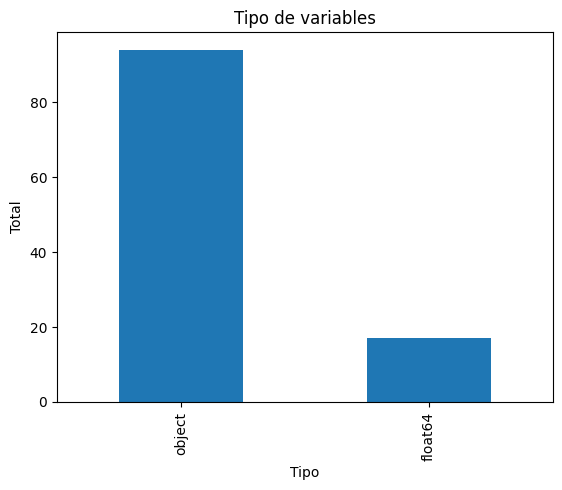

In [ ]:
tipos = pd.DataFrame([df_full.dtypes.index,df_full.dtypes.values]).transpose()
tipos.columns = ['Columna', 'Tipo']

tipos["Tipo"].value_counts().plot(kind='bar')

plt.xlabel('Tipo')
plt.ylabel('Total')
plt.title('Tipo de variables')

plt.show()

Se valida el detalle de las variables categóricas, sin embargo, se observa que varias variables relacionadas con el área del predio aparecen en esta categoría, cuando realmente su naturaleza es numérica, por lo cual se procede a validar estas variables a detalle.

In [ ]:
categoricas=tipos[tipos['Tipo']=='object'].Columna

categoricas.values

array(['objeto', 'motivo', 'proposito', 'tipo_avaluo', 'tipo_credito',
       'departamento_inmueble', 'sector', 'alcantarillado_en_el_sector',
       'acueducto_en_el_sector', 'gas_en_el_sector',
       'energia_en_el_sector', 'telefono_en_el_sector',
       'vias_pavimentadas', 'sardineles_en_las_vias',
       'andenes_en_las_vias', 'barrio_legal', 'topografia_sector',
       'condiciones_salubridad', 'transporte', 'demanda_interes',
       'paradero', 'alumbrado', 'arborizacion', 'alamedas', 'ciclo_rutas',
       'nivel_equipamiento_comercial', 'alcantarillado_en_el_predio',
       'acueducto_en_el_predio', 'gas_en_el_predio',
       'energia_en_el_predio', 'telefono_en_el_predio', 'tipo_inmueble',
       'clase_inmueble', 'ocupante', 'sometido_a_propiedad_horizontal',
       'altura_permitida', 'aislamiento_posterior', 'aislamiento_lateral',
       'antejardin', 'indice_ocupacion', 'indice_construccion',
       'predio_subdividido_fisicamente', 'area_valorada', 'porteria',
       '

Se procede a la identificación de los registritos que vuelven a la variable categórica, posteriormente son eliminados 42 registros.

In [ ]:
valida_str=[
    "area_valorada",
    "area_privada",
    "area_garaje",
    "area_deposito",
    "area_terreno",
    "area_construccion",
    "area_otros"
#    "area_libre"

    ]

def valida_strig(x):
    cont=0
    try:
        float(x)
        return True
    except:
        cont=cont+1
        return False

filtro3= df_full[valida_str].applymap(valida_strig)
df_full= df_full.loc[filtro3.all(axis=1)]
df_full



,id,objeto,motivo,proposito,tipo_avaluo,tipo_credito,departamento_inmueble,sector,alcantarillado_en_el_sector,acueducto_en_el_sector,...,area_privada,area_garaje,area_deposito,area_terreno,valor_area_terreno,area_construccion,area_otros,area_libre,valor_total_avaluo,Base
0,5896.0,remate,remates,garantia hipotecaria,remates,vivienda,valle del cauca,urbano,si,si,...,0,0,0,253.4,63350000.0,131.15,0,no,145318750.0,entrenamiento
1,10570.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,quindio,urbano,si,si,...,254.98,0,0,0,0.0,0,157,no,713986654.0,entrenamiento
2,14600.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,antioquia,urbano,si,si,...,82,13.21,1.02,0,0.0,0,0,si,270500000.0,entrenamiento
3,5967.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,cundinamarca,urbano,si,si,...,48.48,0,0,0,0.0,0,0,no,84840000.0,entrenamiento
4,15814.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,meta,urbano,si,si,...,0,0,0,104,27040000.0,84.52,0,no,96346400.0,entrenamiento
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11982,934.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,santander,urbano,si,si,...,162.11,0,0,0,0.0,0,0,si,NaN,prueba
11983,14877.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,bolivar,urbano,si,si,...,0,0,0,84,33600000.0,44,0,no,NaN,prueba
11985,8095.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,bogota. d. c.,urbano,si,si,...,0,0,0,42,31500000.0,29.68,0,no,NaN,prueba
11986,7435.0,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,santander,urbano,si,si,...,0,0,0,40,22000000.0,56,0,no,NaN,prueba


Una vez eliminados los registros se procede a cambiar el tipo de variable.

In [ ]:
for var in valida_str:
    df_full[var]=df_full[var].astype('float64')

<ipython-input-35-04678d0bc3a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full[var]=df_full[var].astype('float64')
<ipython-input-35-04678d0bc3a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full[var]=df_full[var].astype('float64')
<ipython-input-35-04678d0bc3a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

Como paso final en la limpieza de información, se divide la base de datos en variables categóricas y variables numéricas, con el fin de realizar un análisis adiciona.

In [ ]:
tipos = pd.DataFrame([df_full.dtypes.index,df_full.dtypes.values]).transpose()
tipos.columns = ['Columna', 'Tipo']

categoricas=tipos[tipos['Tipo']=='object'].Columna
numericas=tipos[tipos['Tipo']=='float64'].Columna


Por el frente de las variables categóricas, ya se ha realizado una estandarización de la información, sin embargo, en algunas variables se tienen categorías con muy poca información, para lo cual se creará la categoría otros, en donde se incluirán todos los registros que pertenezca a una categoría que tenga un tamaño menor al 5% de la base total (570 registros).

In [ ]:
df_categoricas=df_full[categoricas]
df_categoricas.head()

,objeto,motivo,proposito,tipo_avaluo,tipo_credito,departamento_inmueble,sector,alcantarillado_en_el_sector,acueducto_en_el_sector,gas_en_el_sector,...,calidad_acabados_banos,estado_acabados_cocina,calidad_acabados_cocina,tipo_garaje,garaje_cubierto_1,garaje_doble_1,garaje_paralelo_1,garaje_servidumbre_1,area_libre,Base
0,remate,remates,garantia hipotecaria,remates,vivienda,valle del cauca,urbano,si,si,si,...,normal,bueno,integral,no tiene,no,0,0,0,no,entrenamiento
1,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,quindio,urbano,si,si,si,...,lujoso,bueno,integral,no tiene,no,0,0,0,no,entrenamiento
2,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,antioquia,urbano,si,si,si,...,normal,bueno,integral,privado,si,no,no,no,si,entrenamiento
3,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,cundinamarca,urbano,si,si,si,...,sencillo,sin acabados,sencillo,no tiene,no,0,0,0,no,entrenamiento
4,originacion,credito hipotecario de vivienda,garantia hipotecaria,hipotecario,vivienda,meta,urbano,si,si,si,...,normal,bueno,sencillo,no tiene,no,0,0,0,no,entrenamiento


In [ ]:
umbral = 570
categ_eliminar=[]

for var in df_categoricas.columns:

    frecuencia = df_categoricas[var].value_counts()
    cat_pocas_obs = frecuencia[frecuencia <= umbral].index

    df_categoricas[var] = df_categoricas[var].apply(lambda x: 'Otros' if x in cat_pocas_obs else x)

    if (frecuencia.count() <=2 and frecuencia.min() <= umbral and var != 'Base'   ):
        categ_eliminar.append(var)




<ipython-input-38-e56142ffdea9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categoricas[var] = df_categoricas[var].apply(lambda x: 'Otros' if x in cat_pocas_obs else x)
<ipython-input-38-e56142ffdea9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categoricas[var] = df_categoricas[var].apply(lambda x: 'Otros' if x in cat_pocas_obs else x)
<ipython-input-38-e56142ffdea9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

Adicionalmente, se identifican variables que tengan 2 categorías y que una de ellas tenga un tamaño menor al 5% de la información total, esto porque son variable consideradas sin variabilidad, lo cual no aporta información relevante al modelo, por lo cual se procede a eliminarlas.

In [ ]:
df_categoricas.drop(columns=categ_eliminar, inplace=True)
df_categoricas

<ipython-input-39-b3f9f54c7707>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categoricas.drop(columns=categ_eliminar, inplace=True)


,motivo,proposito,departamento_inmueble,vias_pavimentadas,sardineles_en_las_vias,andenes_en_las_vias,topografia_sector,condiciones_salubridad,transporte,demanda_interes,...,calidad_acabados_banos,estado_acabados_cocina,calidad_acabados_cocina,tipo_garaje,garaje_cubierto_1,garaje_doble_1,garaje_paralelo_1,garaje_servidumbre_1,area_libre,Base
0,Otros,garantia hipotecaria,valle del cauca,si,si,si,plano,buenas,bueno,media,...,normal,bueno,integral,no tiene,no,0,0,0,no,entrenamiento
1,credito hipotecario de vivienda,garantia hipotecaria,Otros,si,si,si,ligera,buenas,bueno,media,...,Otros,bueno,integral,no tiene,no,0,0,0,no,entrenamiento
2,credito hipotecario de vivienda,garantia hipotecaria,antioquia,si,si,si,ligera,buenas,bueno,media,...,normal,bueno,integral,privado,si,no,no,no,si,entrenamiento
3,credito hipotecario de vivienda,garantia hipotecaria,cundinamarca,si,si,si,plano,buenas,bueno,media,...,sencillo,Otros,sencillo,no tiene,no,0,0,0,no,entrenamiento
4,credito hipotecario de vivienda,garantia hipotecaria,Otros,no,si,si,plano,buenas,bueno,media,...,normal,bueno,sencillo,no tiene,no,0,0,0,no,entrenamiento
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11982,credito hipotecario de vivienda,garantia hipotecaria,Otros,si,si,si,plano,buenas,bueno,Otros,...,normal,Otros,sencillo,no tiene,no,0,0,0,si,Otros
11983,credito hipotecario de vivienda,garantia hipotecaria,Otros,si,si,si,plano,buenas,bueno,media,...,sencillo,bueno,sencillo,no tiene,no,0,0,0,no,Otros
11985,credito hipotecario de vivienda,garantia hipotecaria,bogota. d. c.,si,si,si,ligera,buenas,bueno,media,...,normal,bueno,semi-integral,no tiene,no,0,0,0,no,Otros
11986,credito hipotecario de vivienda,garantia hipotecaria,Otros,si,si,si,plano,buenas,bueno,Otros,...,normal,bueno,sencillo,no tiene,no,0,0,0,no,Otros


Una vez analizada la información categórica, se procede a unirla con las variables numéricas, esto se realiza porque el tratamiento que se dará a las variables numéricas es la detección de datos atípicos, los cuales serán eliminados por el impacto que generan en el comportamiento de la variable.

In [ ]:
df_numericas=df_full[numericas]
df_full=pd.concat([df_categoricas,df_numericas], axis=1)
df_full.head()

,motivo,proposito,departamento_inmueble,vias_pavimentadas,sardineles_en_las_vias,andenes_en_las_vias,topografia_sector,condiciones_salubridad,transporte,demanda_interes,...,oficina,bodega,area_privada,area_garaje,area_deposito,area_terreno,valor_area_terreno,area_construccion,area_otros,valor_total_avaluo
0,Otros,garantia hipotecaria,valle del cauca,si,si,si,plano,buenas,bueno,media,...,0.0,0.0,0.00,0.00,0.00,253.4,63350000.0,131.15,0.0,145318750.0
1,credito hipotecario de vivienda,garantia hipotecaria,Otros,si,si,si,ligera,buenas,bueno,media,...,0.0,0.0,254.98,0.00,0.00,0.0,0.0,0.00,157.0,713986654.0
2,credito hipotecario de vivienda,garantia hipotecaria,antioquia,si,si,si,ligera,buenas,bueno,media,...,0.0,0.0,82.00,13.21,1.02,0.0,0.0,0.00,0.0,270500000.0
3,credito hipotecario de vivienda,garantia hipotecaria,cundinamarca,si,si,si,plano,buenas,bueno,media,...,0.0,0.0,48.48,0.00,0.00,0.0,0.0,0.00,0.0,84840000.0
4,credito hipotecario de vivienda,garantia hipotecaria,Otros,no,si,si,plano,buenas,bueno,media,...,0.0,0.0,0.00,0.00,0.00,104.0,27040000.0,84.52,0.0,96346400.0


Se genera un descriptivo de las variables numéricas para determinar si estas presentan un dato atípico.

In [ ]:
print(df_full[numericas].describe(percentiles=[0.8,0.9,0.95,0.97,0.99] ))

                 id       estrato  area_valorada  bano_social  bano_servicio  \
count  11403.000000  11403.000000   11403.000000  11403.00000   11403.000000   
mean    9262.271244      3.367710     669.711791      1.01789       0.118741   
std     5251.714430      1.238212    9285.397966      0.75957       0.355283   
min        1.000000      1.000000       0.000000      0.00000       0.000000   
50%     9277.000000      3.000000      74.420000      1.00000       0.000000   
80%    14746.200000      4.000000     120.064000      1.00000       0.000000   
90%    16541.800000      5.000000     165.142000      2.00000       1.000000   
95%    17446.900000      6.000000     217.508000      2.00000       1.000000   
97%    17780.940000      6.000000     265.826400      3.00000       1.000000   
99%    18134.980000      6.000000     440.000000      3.00000       1.000000   
max    18331.000000      6.000000  376582.000000     14.00000      11.000000   

             cocina       estudio      

Se realiza la eliminación de 7 variables, ya que al ver su descriptivo el 95% de información o más es un valor único, por lo cual se entiende que dicha variable no presenta variabilidad y puede afectar el entrenamiento del modelo.

In [ ]:
df_full.drop(columns=["oficina","bodega","area_otros","area_deposito","jardin","local","zona_verde_privada"], inplace=True)

Adicionalmente, se identifican 6 variables que presentan datos atípicos, por lo cual se procede al calculo del cuantil 0.995 de cada variable, eliminando los registros que presenten valores por arriba del umbral fijado. Eliminando un total de 305 registros.

In [ ]:
atipico=["area_valorada","area_privada","area_garaje","area_terreno","valor_area_terreno","area_construccion"]

filtro4=df_full[atipico]

for var in atipico:
    upper_q = filtro4[var].quantile(0.995)
    filtro4[var] = filtro4[var] > upper_q

filtro4 =  ~filtro4

df_full= df_full.loc[filtro4.all(axis=1)]
df_full


<ipython-input-43-0b3e6e48d3a1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtro4[var] = filtro4[var] > upper_q
<ipython-input-43-0b3e6e48d3a1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtro4[var] = filtro4[var] > upper_q
<ipython-input-43-0b3e6e48d3a1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

,motivo,proposito,departamento_inmueble,vias_pavimentadas,sardineles_en_las_vias,andenes_en_las_vias,topografia_sector,condiciones_salubridad,transporte,demanda_interes,...,balcon,terraza,patio_interior,zona_de_ropas,area_privada,area_garaje,area_terreno,valor_area_terreno,area_construccion,valor_total_avaluo
0,Otros,garantia hipotecaria,valle del cauca,si,si,si,plano,buenas,bueno,media,...,0.0,0.0,1.0,1.0,0.00,0.00,253.4,63350000.0,131.15,145318750.0
1,credito hipotecario de vivienda,garantia hipotecaria,Otros,si,si,si,ligera,buenas,bueno,media,...,1.0,1.0,0.0,1.0,254.98,0.00,0.0,0.0,0.00,713986654.0
2,credito hipotecario de vivienda,garantia hipotecaria,antioquia,si,si,si,ligera,buenas,bueno,media,...,1.0,1.0,0.0,1.0,82.00,13.21,0.0,0.0,0.00,270500000.0
3,credito hipotecario de vivienda,garantia hipotecaria,cundinamarca,si,si,si,plano,buenas,bueno,media,...,1.0,0.0,0.0,1.0,48.48,0.00,0.0,0.0,0.00,84840000.0
4,credito hipotecario de vivienda,garantia hipotecaria,Otros,no,si,si,plano,buenas,bueno,media,...,0.0,0.0,1.0,1.0,0.00,0.00,104.0,27040000.0,84.52,96346400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11982,credito hipotecario de vivienda,garantia hipotecaria,Otros,si,si,si,plano,buenas,bueno,Otros,...,0.0,0.0,0.0,1.0,162.11,0.00,0.0,0.0,0.00,NaN
11983,credito hipotecario de vivienda,garantia hipotecaria,Otros,si,si,si,plano,buenas,bueno,media,...,0.0,1.0,1.0,1.0,0.00,0.00,84.0,33600000.0,44.00,NaN
11985,credito hipotecario de vivienda,garantia hipotecaria,bogota. d. c.,si,si,si,ligera,buenas,bueno,media,...,0.0,1.0,0.0,1.0,0.00,0.00,42.0,31500000.0,29.68,NaN
11986,credito hipotecario de vivienda,garantia hipotecaria,Otros,si,si,si,plano,buenas,bueno,Otros,...,0.0,0.0,1.0,1.0,0.00,0.00,40.0,22000000.0,56.00,NaN


Se procede nuevamente a la generación de la distribución de las variables numéricas del conjunto de datos, donde se observa que ya no se tienen valores atípicos que afecten el análisis.

In [ ]:
tipos = pd.DataFrame([df_full.dtypes.index,df_full.dtypes.values]).transpose()
tipos.columns = ['Columna', 'Tipo']

numericas=tipos[tipos['Tipo']=='float64'].Columna

print(df_full[numericas].describe(percentiles=[0.8,0.9,0.95,0.97,0.99] ))

                 id       estrato  area_valorada   bano_social  bano_servicio  \
count  11098.000000  11098.000000   11098.000000  11098.000000   11098.000000   
mean    9294.282754      3.354478      96.263630      1.011173       0.111822   
std     5249.915448      1.218770     482.860139      0.743396       0.345445   
min        1.000000      1.000000       0.000000      0.000000       0.000000   
50%     9330.500000      3.000000      73.385000      1.000000       0.000000   
80%    14778.600000      4.000000     116.038000      1.000000       0.000000   
90%    16547.300000      5.000000     156.000000      2.000000       1.000000   
95%    17445.150000      6.000000     195.840000      2.000000       1.000000   
97%    17780.090000      6.000000     230.000000      2.000000       1.000000   
99%    18138.030000      6.000000     302.038700      3.000000       1.000000   
max    18331.000000      6.000000   36290.000000     14.000000      11.000000   

             cocina       e

Con las modificaciones realizadas, se observa que ya se cuenta con una base limpia que puede ser utilizada para el entrenamiento del modelo, en donde se cuenta con 11.098 registros (10.742 train y 356 test) y 85 variables, excluyendo las variables *Base* y *id* utilizadas para la marcación de los conjuntos de datos e identificación de registros.

##3 Entrenamiento modelo

Para la fase de entrenamiento del modelo, se tiene en cuenta que la variable respuesta es continua, por lo tanto es un problema de regresión, ahora bien, existen múltiples algoritmos estadísticos que pueden ayudar en esta tarea, por lo cual se van a evaluar los siguientes 4 tipos de modelos:

- Red Neuronal Densa
- Modelo XGBOOST
- Árboles de decisión de Regresión
- Modelo Support Vector machine regression

Antes de realizar el entrenamiento, se filtra la información para únicamente contener la información de entrenamiento, adicionalmente se eliminan las columnas *Id* y *Base*, dado que son identificadores, adicionalmente, se borran los registros que tengan en la variable respuesta un valor de 0 o menor, dado que afectan el análisis.



In [ ]:
df_model=df_full[df_full["Base"] == "entrenamiento"] # Filtro base de entrenamiento
df_model=df_model[df_model["valor_total_avaluo"] > 0] # Eliminar registros con variables respuesta 0
df_model.drop(columns=["id","Base"], inplace=True)

df_model.shape

(10739, 85)

Se dividen las variables en numéricas y categóricas, con el fin de aplicar la técnica de One Hot Encoging sobre lestas últimamas, con el objetivo de crear variables Dummy que reemplacen las categorías existentes, dado que permitirá al modelo una mejor fase de entrenamiento, posteriormente se divide la información en variable respuesta (y) y variables independientes(X)

In [ ]:
tipos = pd.DataFrame([df_model.dtypes.index, df_model.dtypes.values]).transpose()
tipos.columns = ['Columna', 'Tipo']

cat_modelo=tipos[tipos['Tipo']=='object'].Columna
num_modelo=tipos[tipos['Tipo']=='float64'].Columna

df_cat=df_model[cat_modelo]
encoder = OneHotEncoder(sparse=False) # Se genera el encoder
encoded_features = encoder.fit_transform(df_cat) # Se aplica el encoder

df_num=df_model[num_modelo]
df_num.drop(columns=["valor_total_avaluo"], inplace=True)

y=df_model["valor_total_avaluo"].values # variable respuesta
X=np.concatenate([encoded_features, df_num], axis=1) # variables independientes
X.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-46-000887854ecf>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num.drop(columns=["valor_total_avaluo"], inplace=True)


(10739, 203)

## 3.1 Red Neuronal Densa

El entrenamiento de la red neuronal densa se realizará con la ayuda de Tensor Flow, para este modelo se generan las siguientes capas:

- Capa de entrada con 64 neuronas y función de activación *relu*.
- Segunda capa con 64 neuronas y función de activación *relu*.
- Capa de Dropout del 0.2.
- Capa de salida.

In [ ]:
#Definimos el modelo en keras
model = tf.keras.models.Sequential()

#Capa de entrada
tam  = X.shape[1]

#Primer capa densa
model.add(tf.keras.layers.Dense(units=64, activation='relu', input_shape=(tam,) ))


#Segunda capa densa
model.add(tf.keras.layers.Dense(units=64, activation='relu' ))


model.add(tf.keras.layers.Dropout(0.2))

# Capa de salida
model.add(tf.keras.layers.Dense(units=1))

Se valida la arquitectura de la red propuesta.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                13056     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17281 (67.50 KB)
Trainable params: 17281 (67.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


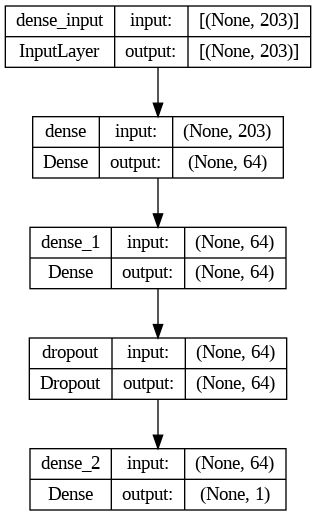

In [ ]:
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True)

Se realiza la compilación del modelo, donde como función de perdida se utilizará *mean_squared_error* teniendo en cuenta que es un problema de regresión, adicionalmente, se utilizará la métrica MAPE, ya que el ejercicio así lo solicita.

In [ ]:
model.compile(loss='mean_squared_error', #Función de perdida para respuesta continua
                 optimizer=tf.optimizers.Adam(learning_rate=1e-4),
                 metrics = ["mean_absolute_percentage_error"]) #Métrica MAPE

Se define un checkpoint que permite guardar los mejores pesos del entrenamiento para poder usarlos posteriormente. Adicionalmente, definimos un criterio de parada para evitar el sobreajuste del modelo, este con una paciencia de 10 épocas. Finalmente, entrenamos el modelo.

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                  filepath='best_weights.h5',
                  monitor="val_mean_absolute_percentage_error",
                  mode="min",
                  save_best_only=True,
                  save_weights_only=True
              )

stopping = tf.keras.callbacks.EarlyStopping(
                monitor="val_mean_absolute_percentage_error",
                patience=10,
                mode="min",
                restore_best_weights=True
            )

# Entrenamos el modelo
history = model.fit( X,y,
                       epochs=50,
                       validation_split=0.2, #20% del conjunto para validación
                       batch_size=32,
                       callbacks=[checkpoint, stopping] )

Epoch 1/50
269/269 [==============================] - 2s 4ms/step - loss: 3574979620729859866624.0000 - mean_absolute_percentage_error: 99.0452 - val_loss: 1276993844753555521536.0000 - val_mean_absolute_percentage_error: 98.6462
Epoch 2/50
269/269 [==============================] - 1s 3ms/step - loss: 3574974554180279074816.0000 - mean_absolute_percentage_error: 98.2465 - val_loss: 1276992155903695257600.0000 - val_mean_absolute_percentage_error: 97.7418
Epoch 3/50
269/269 [==============================] - 1s 2ms/step - loss: 3574968924680744861696.0000 - mean_absolute_percentage_error: 97.1217 - val_loss: 1276990185578858283008.0000 - val_mean_absolute_percentage_error: 96.5583
Epoch 4/50
269/269 [==============================] - 1s 2ms/step - loss: 3574965546981024333824.0000 - mean_absolute_percentage_error: 95.8665 - val_loss: 1276988637466486374400.0000 - val_mean_absolute_percentage_error: 95.2527
Epoch 5/50
269/269 [==============================] - 1s 2ms/step - loss: 357495

Se grafica el comportamiento de la métrica MAPE en el conjunto de entrenamiento y validación.

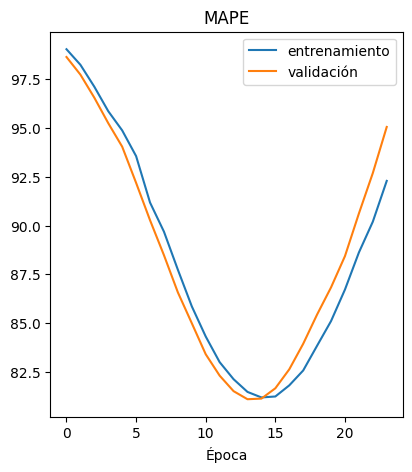

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(history.history["mean_absolute_percentage_error"], label="entrenamiento")
plt.plot(history.history["val_mean_absolute_percentage_error"], label="validación")
plt.title("MAPE"); plt.xlabel("Época"); plt.legend()

Se observa que el valor mínimo del MAPE se alcanza en el epoch 12, con un valor aproximado de 81.1. Teniendo en cuenta que el MAPE se considera bueno con valores cercanos a 0, se descarta este modelo por su pésimo desempeño.

## 3.2 Modelo XGBOOST

Los modelos restantes, serán entrenados con la ayuda de la librería de Sklearn, sin embargo, esta librería no cuenta con la métrica MAPE disponible para la optimización de los modelos, por lo cual se procede a la definición de la misma como función, adicionalmente se genera scorer lo cual permitirá utilizar la nueva función dentro de *GridSearchCV*.

In [ ]:
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

scorer = make_scorer(MAPE, greater_is_better=False)  # Se genera el Score usando el MAPE

Para el entrenamiento del modelo de XGBoost se hace un entrenamiento del modelo sobre múltiples hiper parámetros, para posteriormente elegir el mejor de ellos y calcular la métrica de MAPE.

In [ ]:
modelo_xgb = xgb.XGBRegressor() # Se carga modelo Base

param_grid_xbg = { #Definición de hiper parámetros
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05],
    'gamma': [0, 0.1]
}


grid_search_xgb = GridSearchCV(estimator=modelo_xgb, param_grid=param_grid_xbg, scoring=scorer, cv=5, verbose=1, n_jobs=-1) #Definición de GridSearchCV

grid_search_xgb.fit(X, y) # Ajuste del modelo

print(f'Mejores hiperparámetros encontrados: {grid_search_xgb.best_params_}')

best_model_xgb = grid_search_xgb.best_estimator_ #Selección del modelo

y_pred_xgb = best_model_xgb.predict(X) # Predicción de variable sobre conjunto de entrenamiento

mape_xgb = MAPE(y, y_pred_xgb)
mse_xgb  = mean_squared_error(y, y_pred_xgb)

print(f'MAPE para el XGBoost : {mape_xgb}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mejores hiperparámetros encontrados: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
MAPE para el XGBoost : 342759.30788753123


Al revisar el valor del MAPE para el mejor modelo, se encuentra que este es del  342759.3, lo cual indica que también es un malo modelo, ya que es un valor muy lejano a cero, sugiriendo un mal ajuste del modelo.

##3.3 Árboles de decisión de Regresión

Al igual que el modelo anterior, para el entrenamiento del modelo de árboles de decisión de regresión se hace un entrenamiento del modelo sobre múltiples hiper parámetros, para posteriormente elegir el mejor de ellos y calcular la métrica de MAPE.

In [ ]:
model_DTR = DecisionTreeRegressor(random_state=42) # Se carga el modelo

param_grid_DTR  = { #Definición de hiper parámetros
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_DTR  = GridSearchCV(estimator=model_DTR , param_grid=param_grid_DTR , cv=5, verbose=1 , scoring=scorer) #Definición de GridSearchCV

grid_search_DTR.fit(X, y) # Ajuste del modelo

print(f'Mejores hiperparámetros encontrados: {grid_search_DTR.best_params_}')

best_model_DTR = grid_search_DTR.best_estimator_ #Selección del modelo

y_pred_DTR = best_model_DTR.predict(X) # Predicción de variable sobre conjunto de entrenamiento

mape_DTR = MAPE(y, y_pred_DTR)
mse_DTR = mean_squared_error(y, y_pred_DTR)

print(f'MAPE para el árbol de decisión de Regresión : {mape_DTR }')


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Mejores hiperparámetros encontrados: {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2}
MAPE para el árbol de decisión de Regresión : 0.0023815744964974257


Al validar el valor del MAPE, se encuentra que para este modelo se obtiene un valor de aproximadamente 0.0024, lo cual indica que es un modelo optimo que está logrando predecir correctamente la variable respuesta a partir de la información siniestrada.

##3.4 Modelo Support Vector machine regression

Finalmente, para el entrenamiento del modelo de support vector machine se siguen los mismos pasos que pasa los modelos anteriores, se hace un entrenamiento del modelo sobre múltiples hiper parámetros, para posteriormente elegir el mejor de ellos y calcular la métrica de MAPE.

In [ ]:
model_SVR = SVR()

param_grid_SVR = {
    'C': [0.1, 1],
    'gamma': ['scale', 'auto']
}

grid_search_SVR = GridSearchCV(estimator=model_SVR, param_grid=param_grid_SVR, scoring=scorer, cv=2, verbose=1, n_jobs=-1)

grid_search_SVR.fit(X, y)

print(f'Mejores hiperparámetros encontrados: {grid_search_SVR.best_params_}')

best_model_SVR = grid_search_SVR.best_estimator_


# Hacer predicciones con el mejor modelo
y_pred_SVR = best_model_SVR.predict(X)

mape_SVR = MAPE(y, y_pred_SVR)
mse_SVR = mean_squared_error(y, y_pred_SVR)

print(f'MAPE para el Support Vector Machine: {mape_SVR }')



Fitting 2 folds for each of 4 candidates, totalling 8 fits
Mejores hiperparámetros encontrados: {'C': 1, 'gamma': 'auto'}
MAPE para el Support Vector Machine: 550309.8225914659


Con el entramiento del modelo realizado, se obtiene una métrica de MAPE de 550309, el cual, al igual que algunos casos anteriores, indica que el modelo entrenado no tiene un buen ajuste al conjunto de datos.

##3.5 Comparación modelos

Para la elección del mejor modelo, se realizará la comparación de la métrica MAPE obtenida en cada caso, ya que, según lo solicitado, el desempeño de los modelos será medido con dicha métrica. A continuación, se presentan los resultados obtenidos:

In [ ]:
MAPEs=[round(min(  history.history["mean_absolute_percentage_error"]),3) , round(mape_xgb,3), round(mape_DTR,3), round(mape_SVR,3) ]
MSE=[  round(mean_squared_error(y,  model.predict(X))), round(mse_xgb), round(mse_DTR), round(mse_SVR) ]
Modelo=["Red Neuronal", "XGBoosT", "Árboles de decisión de Regresión", "Support Vector machine"]

Resultado_modelos = pd.DataFrame([Modelo, MAPEs, MSE]).transpose()
Resultado_modelos.columns = ['Modelo', 'MAPE', 'MSE']
Resultado_modelos

336/336 [==============================] - 1s 2ms/step


,Modelo,MAPE,MSE
0,Red Neuronal,81.184,3115252217251284123648
1,XGBoosT,342759.308,707480961170108317696
2,Árboles de decisión de Regresión,0.002,52811494924
3,Support Vector machine,550309.823,3114826316933400887296


In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y, y_pred_DTR)

52811494923.85343

Realizando la comparación en las métricas obtenidas, se encuentra que el modelo que mejor se ajusta a los datos y tiene un mejor desempeño es el modelo de Árboles de decisión de Regresión, dado que su MAPE es el menor, adicionalmente, este presenta un valor cercano a cero, lo cual indica que su ajuste es idóneo para estos casos, por lo cual se toma como el modelo ganador.

Adicionalmente, se calcula el MSE para los 4 modelos entrenados, donde se puede observar el mismo comportamiento que en el MAPE. Finalmente vale la pena aclarar que las métricas presentadas son calculadas con el conjunto de entrenamiento, ya que no se tiene variable respuesta en el conjunto test.


##4. Calificación Base test

Una vez entrenado y seleccionado el modelo ganador se procede a generar las predicción para el conjunto de test. Lo primero que se realiza es el filtrado de la información para tener únicamente este conjunto.

In [ ]:
df_test = df_full[df_full["Base"] != "entrenamiento"] # Filtro base de test
df_test.shape

(356, 87)

Se genera un conjunto eliminando las variables de identificación dado que no son requeridas para la ejecución del modelo.

In [ ]:
Vars_test=df_test
Vars_test.drop(columns=["id","Base"], inplace=True)

<ipython-input-59-d84576240e3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Vars_test.drop(columns=["id","Base"], inplace=True)


Para poder ejecutar el modelo de forma correcta, se deber realizar la misma transformación de datos que en el conjunto de entrenamiento, referente a la limpieza y estandarización, ya se cuenta con esta actividad, dado que los conjuntos fueron trabajos al tiempo, solo es requerido aplicar el one hot encoding sobre las variables categóricas.

In [ ]:
var_cat = Vars_test[cat_modelo]
encoded_features_2 = encoder.transform(var_cat) # Se aplica el encoder

var_num = Vars_test[num_modelo]
var_num.drop(columns=["valor_total_avaluo"], inplace=True)

X_test=np.concatenate([encoded_features_2, var_num], axis=1) # variables independientes
X_test.shape

<ipython-input-60-d3c14c5ca1b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_num.drop(columns=["valor_total_avaluo"], inplace=True)


(356, 203)

Se realiza la predicción de la variable respuesta sobre el conjunto de entramiento con el modelo ganador.

In [ ]:
y_test_pred_DTR =  best_model_DTR.predict(X_test) # Predicción de variable sobre conjunto test

Finalmente, se genera el dataframe *predict_prices*, que contiene las variables *id* y *valor_total_avaluo_predict*, el cual será descargado y hace parte de la entrega de este ejercicio. Vale la pena aclarar que el tamaño de esta base es menor al conjunto test que se tenia orginalmente, esto se debe a que en la fase de limpieza se eliminaron algunos registros, teniendo en cuenta que no cumplían con la calidad requerida para el entrenamiento y ejecución del modelo.

In [ ]:
ids=df_full[df_full["Base"] != "entrenamiento"].id

predict_prices=pd.DataFrame({
    "id":ids,
    "valor_total_avaluo_predict":y_test_pred_DTR
})

predict_prices

,id,valor_total_avaluo_predict
11571,2243.0,519588000.0
11572,500.0,71587400.0
11573,12884.0,455280000.0
11574,4019.0,411350000.0
11576,4629.0,352635000.0
...,...,...
11982,934.0,225910000.0
11983,14877.0,78148300.0
11985,8095.0,106051000.0
11986,7435.0,54540000.0


In [ ]:
predict_prices.to_csv('predict_prices.csv', index=False)

## 5. Implementación

En la presente sección se da una arquitectura propuesta para la implementación del modelo desarrollado. Teniendo en cuenta que el modelo fue desarrollado en *Sklearn*, se propone la descarga del modelo en formato *.pkl*, para que el despliegue sea mucho más ágil, adicionalmente se presentan 2 arquitecturas de referencia.

##5.1 Arquitectura Batch

La arquitectura propuesta para la implementación del servicio en Batch es:

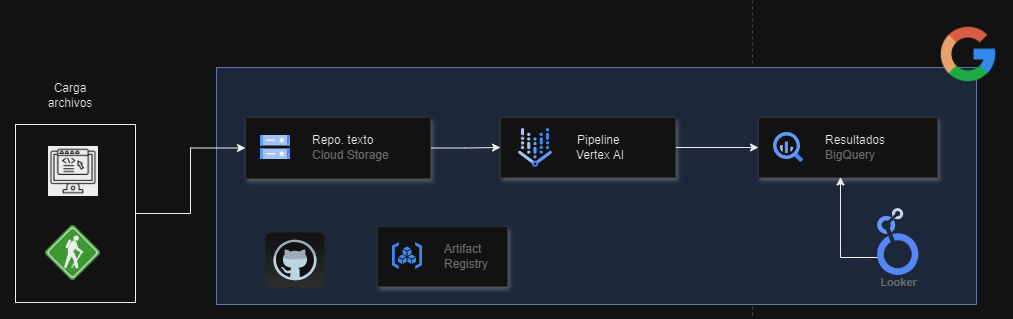

In [ ]:
display(Image("Batch.png", height=400))

- **Cloud Storage**: Repositorio en donde se deben alojar los archivos que contenga la información requerida para la ejecución del modelo.
- **Vertex AI**: Servicio que contendrá el proceso de ELT y ejecución del modelo, realizando la carga del *.plk*.
- **BigQuery**: Repositorio en donde se dejará el resultado del model.
- **Looker**: Servicio que permite la visualización de los resultados de una forma interactiva.
- **GitHub**: Repositorio de código donde también se ejecutarán pruebas unitarias y de vulnerabilidad del código desarrollado.
- **Artifact Registry**: Servicio donde se diponibilizará la imagen creada con el código alojado en GitHub, y será disponibilizada en la instancia de ejecución.
- La carga de la información dependerá de la naturaleza del caso de uso a implementar, si se requiere únicamente la disponibilización del modelo para su uso, se recomiendo el uso de un front, por otro lado, si lo que se requiere es un proceso automático masivo, se recomiendan herramientas tipo go anywhere para el cargue de la información.


##5.2 Arquitectura Real Time

Referente a la implementación del proceso en Real time se propone el uso de la siguiente arquitectura.

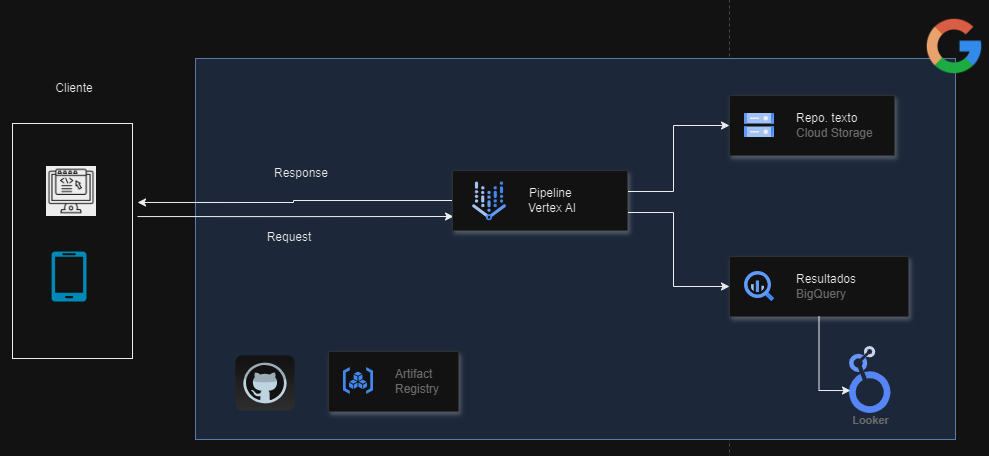

In [ ]:
display(Image("Real time 2.png", height=500))

- **Cloud Storage**: Repositorio en donde se deben alojar los archivos que contenga la información requerida para la ejecución del modelo.  
- **Vertex AI**: Servicio que contendrá el proceso de ELT y ejecución del modelo, realizando la carga del *.plk*. Se disponibiliza mediante el servicio de Vertex Endpoints.
- **BigQuery**: Repositorio en donde se dejará el resultado del model.
- **Looker**: Servicio que permite la visualización de los resultados de una forma interactiva.
- **GitHub**: Repositorio de código donde también se ejecutarán pruebas unitarias y de vulnerabilidad del código desarrollado.
- **Artifact Registry**: Servicio donde se diponibilizará la imagen creada con el código alojado en GitHub, y será disponibilizada en la instancia de ejecución.
- Al disponibilizar el desarrollo como un api, se garantiza que pueda ser llamado por cualquier aplicativo, incluyendo apps de celulares o un front de atención.

Adicionalmente, para la exposición del API se deben considerar los lineamientos dados por el equipo de seguridad, con el fin de determinar el camino más adecuado y seguro de implementación, en donde se considerará quien será el cliente final que consumirá dicha API.

## 6. Conclusiones

Con el fin de poder generar una herramienta que permita ayudar en la tarea de estimación de precios de vivienda, se han entrenado múltiples modelos que permitan generar un precio estimado a partir de ciertas características que se pueden extraer de las propiedades, obteniendo que para este ejercicio en particular, un modelo de árboles de decisión de regresión presenta el mejor ajuste en comparación a las otros algoritmos evaluados.

Este resultado da alcance al objetivo planteado del desarrollo del modelo, sin embargo, para su uso de una manera automática se recomienda la industrialización del proceso, donde adicionalmente, se recomienda la estandarización en la obtención de la información, dado que uno de los principales retos del ejercicio fue asegurar la calidad de la misma, a futuro, se recomienda un formulario con respuesta estandarizadas para garantizar la mejor la calidad de datos disponibles, siempre teniendo en cuenta que un bueno modelo y sus resultados dependen en gran medida de la calidad de la información.
